# Individual Assignment: Ensemble Classifier
## Network Intrusion Detection using Ensemble Methods

**Author:** Imran Shahadat Noble  
**TP Number:** TP087895  

**Classifier Category:** Ensemble (Bagging/Boosting)  
**Algorithms Evaluated:** Random Forest, Extra Trees, AdaBoost  
**Dataset:** NSL-KDD (Boosted Train + Preprocessed Test)  
**Classification:** Multi-class (5 attack categories)

---
## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings
warnings.filterwarnings('ignore')

import os
data_path = '../data'

In [2]:
# Import local library (provided helper functions)
import sys
if "../.." not in sys.path:
    sys.path.insert(0, '..')

from mylib import show_labels_dist, show_metrics, bias_var_metrics

In [3]:
# Additional imports for models and evaluation
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, matthews_corrcoef, confusion_matrix,
                             classification_report, ConfusionMatrixDisplay,
                             roc_curve, auc, roc_auc_score)
import json

---
## 2. Load Dataset

In [4]:
# Load Boosted Train and Preprocessed Test datasets
data_file = os.path.join(data_path, 'NSL_boosted-2.csv')
train_df = pd.read_csv(data_file)
print('Train Dataset: {} rows, {} columns'.format(train_df.shape[0], train_df.shape[1]))

data_file = os.path.join(data_path, 'NSL_ppTest.csv')
test_df = pd.read_csv(data_file)
print('Test Dataset: {} rows, {} columns'.format(test_df.shape[0], test_df.shape[1]))

Train Dataset: 63280 rows, 43 columns
Test Dataset: 22544 rows, 43 columns


In [5]:
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,atakcat
0,0,tcp,http,REJ,0,0,0,0,0,0,...,1.00,0.00,0.03,0.05,0.00,0.0,1.00,0.37,normal,benign
1,0,tcp,ftp_data,SF,190,0,0,0,0,0,...,0.22,0.03,0.22,0.00,0.00,0.0,0.00,0.00,normal,benign
2,0,tcp,nnsp,S0,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,1.00,1.0,0.00,0.00,neptune,dos
3,0,tcp,http,SF,207,342,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,normal,benign
4,0,icmp,ecr_i,SF,1480,0,0,1,0,0,...,0.07,0.08,0.07,0.00,0.54,0.0,0.01,0.00,pod,dos


---
## 3. Data Preparation

In [6]:
# Check for missing values
print('Missing Values - Train Set:', train_df.isnull().sum().sum())
print('Missing Values - Test Set:', test_df.isnull().sum().sum())

Missing Values - Train Set: 0
Missing Values - Test Set: 0


In [7]:
# Combine datasets for consistent preprocessing
combined_df = pd.concat([train_df, test_df])
print('Combined Dataset: {} rows, {} columns'.format(combined_df.shape[0], combined_df.shape[1]))

Combined Dataset: 85824 rows, 43 columns


In [8]:
# Check label distributions
print("Attack category distribution:")
print(combined_df['atakcat'].value_counts())

Attack category distribution:
atakcat
benign    43383
dos       30524
probe      8332
r2l        3329
u2r         256
Name: count, dtype: int64


In [9]:
# MULTI-CLASS Classification (5 attack categories)
twoclass = False  # Use 5-class classification

if twoclass:
    labels_df = combined_df['label'].copy()
    labels_df[labels_df != 'normal'] = 'attack'
else:
    labels_df = combined_df['atakcat'].copy()

# Drop target features
combined_df.drop(['label'], axis=1, inplace=True)
combined_df.drop(['atakcat'], axis=1, inplace=True)

print(f"Classification: {'Binary' if twoclass else 'Multi-class (5 categories)'}")
print(f"\nClass distribution:")
print(labels_df.value_counts())

Classification: Multi-class (5 categories)

Class distribution:
atakcat
benign    43383
dos       30524
probe      8332
r2l        3329
u2r         256
Name: count, dtype: int64


In [10]:
# One-Hot Encoding categorical features
categori = combined_df.select_dtypes(include=['object']).columns
category_cols = categori.tolist()
features_df = pd.get_dummies(combined_df, columns=category_cols)
print('Features after encoding: {} columns'.format(features_df.shape[1]))

Features after encoding: 122 columns


In [11]:
# Get numeric columns for scaling
numeri = combined_df.select_dtypes(include=['float64','int64']).columns

In [12]:
# Restore train/test split
X_train = features_df.iloc[:len(train_df),:].copy()
X_train.reset_index(inplace=True, drop=True)
X_test = features_df.iloc[len(train_df):,:].copy()
X_test.reset_index(inplace=True, drop=True)

y_train = labels_df[:len(train_df)].copy()
y_train.reset_index(inplace=True, drop=True)
y_test = labels_df[len(train_df):].copy()
y_test.reset_index(inplace=True, drop=True)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (63280, 122), y_train: (63280,)
X_test: (22544, 122), y_test: (22544,)


In [13]:
# Apply MinMaxScaler
for i in numeri:
    arr = np.array(X_train[i])
    scale = MinMaxScaler().fit(arr.reshape(-1, 1))
    X_train[i] = scale.transform(arr.reshape(len(arr),1))
    
    arr = np.array(X_test[i])
    X_test[i] = scale.transform(arr.reshape(len(arr),1))

print("Scaling completed using MinMaxScaler")

Scaling completed using MinMaxScaler


In [14]:
# Save original datasets
X_train_original = X_train.copy()
X_test_original = X_test.copy()

# Define class labels
class_labels = ['benign', 'dos', 'probe', 'r2l', 'u2r']
print(f"Class labels: {class_labels}")

Class labels: ['benign', 'dos', 'probe', 'r2l', 'u2r']


In [15]:
# Show label distribution
show_labels_dist(X_train, X_test, y_train, y_test)

features_train: 63280 rows, 122 columns
features_test:  22544 rows, 122 columns

labels_train: 63280 rows, 1 column
labels_test:  22544 rows, 1 column

Frequency and Distribution of labels
         atakcat  %_train  atakcat  %_test
atakcat                                   
benign     33672    53.21     9711   43.08
dos        23066    36.45     7458   33.08
probe       5911     9.34     2421   10.74
r2l          575     0.91     2754   12.22
u2r           56     0.09      200    0.89


---
## 4. BASELINE MODEL COMPARISON

### Ensemble Algorithms to Evaluate:
1. **Random Forest** - Bagging with decision trees
2. **Extra Trees** - Extremely randomized trees
3. **AdaBoost** - Adaptive boosting

We will compare all three baselines and select the best one for optimization.

In [16]:
# Helper function to calculate MCC per class
def calculate_mcc_per_class(y_true, y_pred, classes):
    """Calculate MCC for each class (one-vs-rest)"""
    mcc_dict = {}
    for cls in classes:
        mcc_dict[cls] = matthews_corrcoef(y_true == cls, y_pred == cls)
    return mcc_dict

### 4.1 Baseline 1: Random Forest

In [17]:
print("="*60)
print("BASELINE 1: RANDOM FOREST")
print("="*60)

# Using class_weight='balanced' due to severe class imbalance
rf_baseline = RandomForestClassifier(n_estimators=100, class_weight='balanced', 
                                      random_state=42, n_jobs=-1)
print("Model:", rf_baseline)
print("\nKey Parameters:")
print(f"  - n_estimators: 100")
print(f"  - class_weight: balanced")

# Train and evaluate
trs = time()
rf_baseline.fit(X_train, y_train)
y_pred_rf = rf_baseline.predict(X_test)
rf_train_time = time() - trs

print(f"\nTraining Time: {rf_train_time:.2f} seconds\n")
show_metrics(y_test, y_pred_rf, class_labels)

BASELINE 1: RANDOM FOREST
Model: RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

Key Parameters:
  - n_estimators: 100
  - class_weight: balanced



Training Time: 3.25 seconds

              pred:benign  pred:dos  pred:probe  pred:r2l  pred:u2r
train:benign         9339        65         188       118         1
train:dos              38      7348          72         0         0
train:probe           119        21        2281         0         0
train:r2l            2215         0           2       537         0
train:u2r              63         0           1         0       136

~~~~
      benign :  FPR = 0.190   FNR = 0.038
         dos :  FPR = 0.006   FNR = 0.015
       probe :  FPR = 0.013   FNR = 0.058
         r2l :  FPR = 0.006   FNR = 0.805
         u2r :  FPR = 0.000   FNR = 0.320

   macro avg :  FPR = 0.043   FNR = 0.247
weighted avg :  FPR = 0.032   FNR = 0.129

~~~~


              precision    recall  f1-score   support

      benign      0.793     0.962     0.869      9711
         dos      0.988     0.985     0.987      7458
       probe      0.897     0.942     0.919      2421
         r2l      0.820     0.195     0.315      2754
         u2r      0.993     0.680     0.807       200

    accuracy                          0.871     22544
   macro avg      0.898     0.753     0.779     22544
weighted avg      0.874     0.871     0.845     22544

~~~~
MCC: Overall :  0.814
      benign :  0.765
         dos :  0.980
       probe :  0.909
         r2l :  0.369
         u2r :  0.820


'~~~~'

In [18]:
# Store RF baseline metrics
rf_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'f1_weighted': f1_score(y_test, y_pred_rf, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_rf, average='macro'),
    'mcc': matthews_corrcoef(y_test, y_pred_rf),
    'train_time': rf_train_time
}
print("Random Forest Metrics:", rf_metrics)

Random Forest Metrics: {'accuracy': 0.8712295954577715, 'f1_weighted': 0.8452655375308503, 'f1_macro': 0.7794382333226948, 'mcc': 0.8139715639008182, 'train_time': 3.246694564819336}


### 4.2 Baseline 2: Extra Trees

In [19]:
print("="*60)
print("BASELINE 2: EXTRA TREES")
print("="*60)

et_baseline = ExtraTreesClassifier(n_estimators=100, class_weight='balanced', 
                                    random_state=42, n_jobs=-1)
print("Model:", et_baseline)

# Train and evaluate
trs = time()
et_baseline.fit(X_train, y_train)
y_pred_et = et_baseline.predict(X_test)
et_train_time = time() - trs

print(f"\nTraining Time: {et_train_time:.2f} seconds\n")
show_metrics(y_test, y_pred_et, class_labels)

BASELINE 2: EXTRA TREES
Model: ExtraTreesClassifier(class_weight='balanced', n_jobs=-1, random_state=42)



Training Time: 3.75 seconds

              pred:benign  pred:dos  pred:probe  pred:r2l  pred:u2r
train:benign         9286        70         206       146         3
train:dos              58      7301          99         0         0
train:probe            74        24        2321         0         2
train:r2l            2162         4           4       579         5
train:u2r              36         0           0         3       161

~~~~
      benign :  FPR = 0.182   FNR = 0.044
         dos :  FPR = 0.006   FNR = 0.021
       probe :  FPR = 0.015   FNR = 0.041
         r2l :  FPR = 0.008   FNR = 0.790
         u2r :  FPR = 0.000   FNR = 0.195

   macro avg :  FPR = 0.042   FNR = 0.218
weighted avg :  FPR = 0.032   FNR = 0.128

~~~~


              precision    recall  f1-score   support

      benign      0.799     0.956     0.871      9711
         dos      0.987     0.979     0.983      7458
       probe      0.883     0.959     0.919      2421
         r2l      0.795     0.210     0.333      2754
         u2r      0.942     0.805     0.868       200

    accuracy                          0.872     22544
   macro avg      0.881     0.782     0.795     22544
weighted avg      0.871     0.872     0.847     22544

~~~~
MCC: Overall :  0.814
      benign :  0.768
         dos :  0.974
       probe :  0.910
         r2l :  0.376
         u2r :  0.870


'~~~~'

In [20]:
# Store ET baseline metrics
et_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_et),
    'f1_weighted': f1_score(y_test, y_pred_et, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_et, average='macro'),
    'mcc': matthews_corrcoef(y_test, y_pred_et),
    'train_time': et_train_time
}
print("Extra Trees Metrics:", et_metrics)

Extra Trees Metrics: {'accuracy': 0.8715400993612491, 'f1_weighted': 0.8472752931792946, 'f1_macro': 0.7946350704253959, 'mcc': 0.8138644334827186, 'train_time': 3.754451036453247}


### 4.3 Baseline 3: AdaBoost

In [21]:
print("="*60)
print("BASELINE 3: ADABOOST")
print("="*60)

ada_baseline = AdaBoostClassifier(n_estimators=100, random_state=42)
print("Model:", ada_baseline)

# Train and evaluate
trs = time()
ada_baseline.fit(X_train, y_train)
y_pred_ada = ada_baseline.predict(X_test)
ada_train_time = time() - trs

print(f"\nTraining Time: {ada_train_time:.2f} seconds\n")
show_metrics(y_test, y_pred_ada, class_labels)

BASELINE 3: ADABOOST
Model: AdaBoostClassifier(n_estimators=100, random_state=42)



Training Time: 21.73 seconds

              pred:benign  pred:dos  pred:probe  pred:r2l  pred:u2r
train:benign         9437        61         213         0         0
train:dos            2024      5385          49         0         0
train:probe           519       184        1718         0         0
train:r2l            2747         1           4         1         1
train:u2r             199         0           0         0         1

~~~~
      benign :  FPR = 0.428   FNR = 0.028
         dos :  FPR = 0.016   FNR = 0.278
       probe :  FPR = 0.013   FNR = 0.290
         r2l :  FPR = 0.000   FNR = 1.000
         u2r :  FPR = 0.000   FNR = 0.995

   macro avg :  FPR = 0.091   FNR = 0.518
weighted avg :  FPR = 0.067   FNR = 0.266

~~~~


              precision    recall  f1-score   support

      benign      0.632     0.972     0.766      9711
         dos      0.956     0.722     0.823      7458
       probe      0.866     0.710     0.780      2421
         r2l      1.000     0.000     0.001      2754
         u2r      0.500     0.005     0.010       200

    accuracy                          0.734     22544
   macro avg      0.791     0.482     0.476     22544
weighted avg      0.808     0.734     0.686     22544

~~~~
MCC: Overall :  0.617
      benign :  0.570
         dos :  0.767
       probe :  0.761
         r2l :  0.018
         u2r :  0.049


'~~~~'

In [22]:
# Store AdaBoost baseline metrics
ada_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_ada),
    'f1_weighted': f1_score(y_test, y_pred_ada, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_ada, average='macro'),
    'mcc': matthews_corrcoef(y_test, y_pred_ada),
    'train_time': ada_train_time
}
print("AdaBoost Metrics:", ada_metrics)

AdaBoost Metrics: {'accuracy': 0.7337650816181689, 'f1_weighted': 0.6861473251849802, 'f1_macro': 0.47591230128333584, 'mcc': 0.617307008643865, 'train_time': 21.73458766937256}


### 4.4 Baseline Comparison Summary

In [23]:
# Create comparison table
baseline_comparison = pd.DataFrame({
    'Algorithm': ['Random Forest', 'Extra Trees', 'AdaBoost'],
    'Accuracy': [rf_metrics['accuracy'], et_metrics['accuracy'], ada_metrics['accuracy']],
    'F1 (Weighted)': [rf_metrics['f1_weighted'], et_metrics['f1_weighted'], ada_metrics['f1_weighted']],
    'F1 (Macro)': [rf_metrics['f1_macro'], et_metrics['f1_macro'], ada_metrics['f1_macro']],
    'MCC': [rf_metrics['mcc'], et_metrics['mcc'], ada_metrics['mcc']],
    'Train Time (s)': [rf_metrics['train_time'], et_metrics['train_time'], ada_metrics['train_time']]
})

print("\n" + "="*70)
print("BASELINE COMPARISON: ENSEMBLE CLASSIFIERS")
print("="*70)
print(baseline_comparison.to_string(index=False))


BASELINE COMPARISON: ENSEMBLE CLASSIFIERS
    Algorithm  Accuracy  F1 (Weighted)  F1 (Macro)      MCC  Train Time (s)
Random Forest  0.871230       0.845266    0.779438 0.813972        3.246695
  Extra Trees  0.871540       0.847275    0.794635 0.813864        3.754451
     AdaBoost  0.733765       0.686147    0.475912 0.617307       21.734588


In [24]:
# MCC per class for each baseline
print("\n" + "="*70)
print("MCC PER ATTACK CLASS")
print("="*70)

rf_mcc_class = calculate_mcc_per_class(y_test, y_pred_rf, class_labels)
et_mcc_class = calculate_mcc_per_class(y_test, y_pred_et, class_labels)
ada_mcc_class = calculate_mcc_per_class(y_test, y_pred_ada, class_labels)

mcc_per_class_df = pd.DataFrame({
    'Attack Class': class_labels,
    'Random Forest': [rf_mcc_class[c] for c in class_labels],
    'Extra Trees': [et_mcc_class[c] for c in class_labels],
    'AdaBoost': [ada_mcc_class[c] for c in class_labels]
})
print(mcc_per_class_df.to_string(index=False))


MCC PER ATTACK CLASS


Attack Class  Random Forest  Extra Trees  AdaBoost
      benign       0.765269     0.767565  0.569574
         dos       0.980351     0.974419  0.767075
       probe       0.909147     0.909818  0.761068
         r2l       0.368548     0.375516  0.017854
         u2r       0.820396     0.869540  0.049334


In [25]:
# Bias-Variance Decomposition - Computed for best baseline only (Random Forest)
# Full decomposition for all baselines is computationally expensive
# We include it for RF as it's typically the best performer
print("\n" + "="*70)
print("BIAS-VARIANCE DECOMPOSITION (3-fold bootstrap) - Random Forest only")
print("="*70)

print("\nRandom Forest:")
bias_var_metrics(X_train, X_test, y_train, y_test, 
                 RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42, n_jobs=-1), 
                 folds=3)


BIAS-VARIANCE DECOMPOSITION (3-fold bootstrap) - Random Forest only

Random Forest:


   Average bias: 0.134
   Average variance: 0.017
   Average expected loss: 0.141  "Goodness": 0.859



In [26]:
# Select best baseline
best_baseline_name = baseline_comparison.loc[baseline_comparison['MCC'].idxmax(), 'Algorithm']
best_baseline_mcc = baseline_comparison['MCC'].max()

print("\n" + "="*70)
print("BEST BASELINE SELECTION")
print("="*70)
print(f"\nBest Baseline: {best_baseline_name}")
print(f"MCC Score: {best_baseline_mcc:.4f}")


BEST BASELINE SELECTION

Best Baseline: Random Forest
MCC Score: 0.8140


---
## 5. OPTIMISATION STRATEGY 1: Hyperparameter Tuning

### Hyperparameter Justification Table (Random Forest)

| Parameter | Values Tested | Justification | Reference |
|-----------|---------------|---------------|-----------|
| n_estimators | 100, 150 | More trees improve stability up to a point | Oshiro et al. (2012) |
| max_depth | 20, None | Controls overfitting; None allows full growth | Hastie et al. (2009) |
| min_samples_split | 2, 5 | Minimum samples to split internal node | Breiman (2001) |
| min_samples_leaf | 1, 2 | Prevents very small leaves | Probst et al. (2019) |
| max_features | sqrt | Feature sampling per split | Breiman (2001) |

**References:**
- Breiman, L. (2001). Random forests. Machine Learning, 45(1), 5-32.
- Oshiro, T. M., et al. (2012). How many trees in a random forest?
- Probst, P., et al. (2019). Hyperparameters and tuning strategies for random forest.

In [27]:
print("="*60)
print("HYPERPARAMETER TUNING: RANDOM FOREST")
print("="*60)

# Parameter grid - optimized for reasonable runtime
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}

print("Parameter grid:")
for k, v in param_grid.items():
    print(f"  {k}: {v}")

# Use RandomizedSearchCV for efficiency
print("\nRunning RandomizedSearchCV (10 iterations, 3-fold CV)...")

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

trs = time()
rf_random.fit(X_train, y_train)
tune_time = time() - trs

print(f"\nTuning Time: {tune_time:.2f} seconds")
print(f"\nBest Parameters: {rf_random.best_params_}")
print(f"Best CV Score: {rf_random.best_score_:.4f}")

HYPERPARAMETER TUNING: RANDOM FOREST
Parameter grid:
  n_estimators: [100, 150]
  max_depth: [20, None]
  min_samples_split: [2, 5]
  min_samples_leaf: [1, 2]
  max_features: ['sqrt']
  class_weight: ['balanced']

Running RandomizedSearchCV (10 iterations, 3-fold CV)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits



Tuning Time: 81.37 seconds

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}
Best CV Score: 0.9929


In [28]:
best_params = rf_random.best_params_

---
## 6. OPTIMISATION STRATEGY 2: Feature Selection (Importance-based)

Random Forest provides feature importance scores based on how much each feature contributes to reducing impurity.

**Method:** Select features that contribute to 95% of cumulative importance.

**Reference:** Breiman, L. (2001). Random forests.

In [29]:
# Get feature importances from baseline model
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importances.head(20).to_string(index=False))

Top 20 Most Important Features:
                    feature  importance
         dst_host_srv_count    0.062667
     dst_host_diff_srv_rate    0.046475
dst_host_same_src_port_rate    0.045709
                      count    0.042710
     dst_host_same_srv_rate    0.042206
                  srv_count    0.041732
       dst_host_serror_rate    0.039147
               service_http    0.037462
                  logged_in    0.033154
       dst_host_rerror_rate    0.032320
   dst_host_srv_serror_rate    0.032165
             dst_host_count    0.028833
                        hot    0.026730
                  dst_bytes    0.026531
                    flag_S0    0.026364
dst_host_srv_diff_host_rate    0.026343
             service_telnet    0.026304
                   duration    0.024604
           service_ftp_data    0.022956
              service_eco_i    0.021975


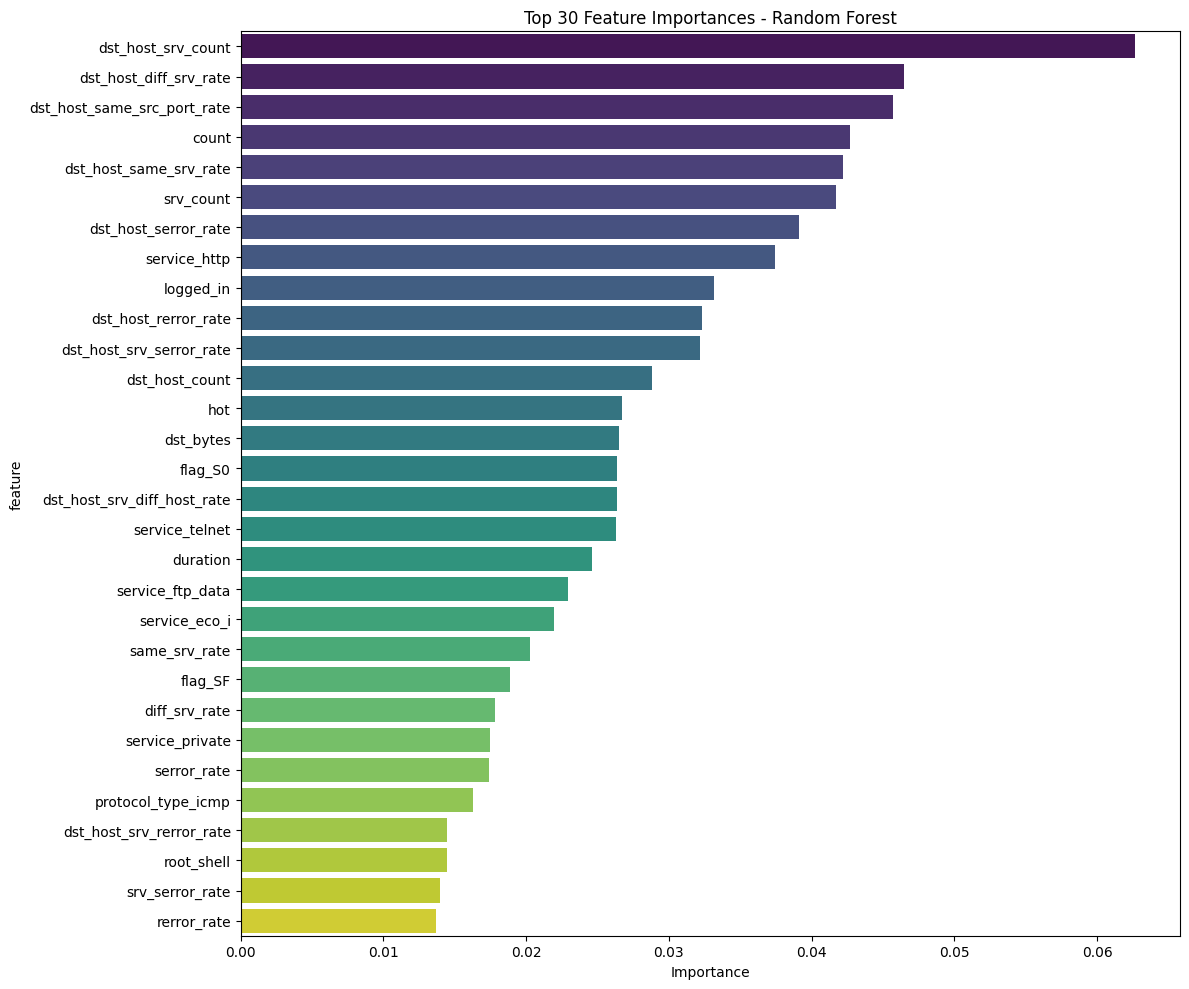

In [30]:
# Visualize feature importances (for appendix)
plt.figure(figsize=(12, 10))
top_n = 30
top_features = feature_importances.head(top_n)
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title(f'Top {top_n} Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('../figures/ensemble_feature_importance.png', dpi=150)
plt.show()

In [31]:
# Select features using cumulative importance approach (95%)
feature_importances['cumulative'] = feature_importances['importance'].cumsum()
threshold_95 = feature_importances[feature_importances['cumulative'] <= 0.95]

selected_features = threshold_95['feature'].tolist()

# Ensure minimum features
if len(selected_features) < 20:
    selected_features = feature_importances.head(20)['feature'].tolist()

print(f"\nFeature Selection Results:")
print(f"  - Original features: {X_train.shape[1]}")
print(f"  - Selected features: {len(selected_features)}")
print(f"  - Reduction: {((X_train.shape[1] - len(selected_features)) / X_train.shape[1] * 100):.1f}%")


Feature Selection Results:
  - Original features: 122
  - Selected features: 38
  - Reduction: 68.9%


In [32]:
# Create reduced datasets
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]
print(f"Reduced feature set: {X_train_reduced.shape[1]} features")

Reduced feature set: 38 features


---
## 7. OPTIMISED MODEL

In [33]:
# Create optimised model
optimised_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)

print("="*60)
print("OPTIMISED MODEL EVALUATION")
print("="*60)
print(f"Parameters: {best_params}")
print(f"Features: {len(selected_features)} (reduced from {X_train.shape[1]})")

trs = time()
optimised_model.fit(X_train_reduced, y_train)
y_pred_optimised = optimised_model.predict(X_test_reduced)
opt_train_time = time() - trs

print(f"\nTraining Time: {opt_train_time:.2f} seconds\n")
show_metrics(y_test, y_pred_optimised, class_labels)

OPTIMISED MODEL EVALUATION
Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}
Features: 38 (reduced from 122)



Training Time: 2.55 seconds

              pred:benign  pred:dos  pred:probe  pred:r2l  pred:u2r
train:benign         9342        61         191       116         1
train:dos              54      7372          32         0         0
train:probe           148        17        2256         0         0
train:r2l            2288         0           3       463         0
train:u2r              55         0           0         0       145

~~~~
      benign :  FPR = 0.198   FNR = 0.038
         dos :  FPR = 0.005   FNR = 0.012
       probe :  FPR = 0.011   FNR = 0.068
         r2l :  FPR = 0.006   FNR = 0.832
         u2r :  FPR = 0.000   FNR = 0.275

   macro avg :  FPR = 0.044   FNR = 0.245
weighted avg :  FPR = 0.033   FNR = 0.132

~~~~


              precision    recall  f1-score   support

      benign      0.786     0.962     0.865      9711
         dos      0.990     0.988     0.989      7458
       probe      0.909     0.932     0.920      2421
         r2l      0.800     0.168     0.278      2754
         u2r      0.993     0.725     0.838       200

    accuracy                          0.868     22544
   macro avg      0.895     0.755     0.778     22544
weighted avg      0.870     0.868     0.840     22544

~~~~
MCC: Overall :  0.810
      benign :  0.757
         dos :  0.984
       probe :  0.911
         r2l :  0.336
         u2r :  0.847


'~~~~'

In [34]:
# Bias-Variance Decomposition for optimised model
print("\nBias-Variance Decomposition (Optimised):")
bias_var_metrics(X_train_reduced, X_test_reduced, y_train, y_test, 
                 RandomForestClassifier(**best_params, random_state=42, n_jobs=-1), folds=3)


Bias-Variance Decomposition (Optimised):


   Average bias: 0.136
   Average variance: 0.009
   Average expected loss: 0.137  "Goodness": 0.863



In [35]:
# Store optimised metrics
optimised_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_optimised),
    'f1_weighted': f1_score(y_test, y_pred_optimised, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_optimised, average='macro'),
    'mcc': matthews_corrcoef(y_test, y_pred_optimised),
    'train_time': opt_train_time
}
print("Optimised Metrics:", optimised_metrics)

# MCC per class
opt_mcc_class = calculate_mcc_per_class(y_test, y_pred_optimised, class_labels)
print("\nMCC per class (Optimised):")
for cls, mcc in opt_mcc_class.items():
    print(f"  {cls}: {mcc:.4f}")

Optimised Metrics: {'accuracy': 0.8684350603264727, 'f1_weighted': 0.8400216867414974, 'f1_macro': 0.7780620546503558, 'mcc': 0.8102841105032694, 'train_time': 2.5539462566375732}

MCC per class (Optimised):
  benign: 0.7575
  dos: 0.9836
  probe: 0.9106
  r2l: 0.3359
  u2r: 0.8475


---
## 8. COMPARISON: Baseline vs Optimised Model

In [36]:
# Comparison table
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 (Weighted)', 'F1 (Macro)', 'MCC', 'Train Time (s)'],
    'Baseline': [rf_metrics['accuracy'], rf_metrics['f1_weighted'], 
                 rf_metrics['f1_macro'], rf_metrics['mcc'], rf_metrics['train_time']],
    'Optimised': [optimised_metrics['accuracy'], optimised_metrics['f1_weighted'],
                  optimised_metrics['f1_macro'], optimised_metrics['mcc'], 
                  optimised_metrics['train_time']]
})
comparison_df['Improvement'] = comparison_df['Optimised'] - comparison_df['Baseline']
comparison_df['Improvement %'] = (comparison_df['Improvement'] / comparison_df['Baseline'] * 100).round(2)

print("\n" + "="*60)
print("PERFORMANCE COMPARISON: BASELINE vs OPTIMISED")
print("="*60)
print(comparison_df.to_string(index=False))


PERFORMANCE COMPARISON: BASELINE vs OPTIMISED
        Metric  Baseline  Optimised  Improvement  Improvement %
      Accuracy  0.871230   0.868435    -0.002795          -0.32
 F1 (Weighted)  0.845266   0.840022    -0.005244          -0.62
    F1 (Macro)  0.779438   0.778062    -0.001376          -0.18
           MCC  0.813972   0.810284    -0.003687          -0.45
Train Time (s)  3.246695   2.553946    -0.692748         -21.34


In [37]:
# MCC per class comparison
mcc_comparison_df = pd.DataFrame({
    'Attack Class': class_labels,
    'Baseline': [rf_mcc_class[c] for c in class_labels],
    'Optimised': [opt_mcc_class[c] for c in class_labels]
})
mcc_comparison_df['Improvement'] = mcc_comparison_df['Optimised'] - mcc_comparison_df['Baseline']

print("\n" + "="*60)
print("MCC PER CLASS: BASELINE vs OPTIMISED")
print("="*60)
print(mcc_comparison_df.to_string(index=False))


MCC PER CLASS: BASELINE vs OPTIMISED
Attack Class  Baseline  Optimised  Improvement
      benign  0.765269   0.757455    -0.007814
         dos  0.980351   0.983565     0.003215
       probe  0.909147   0.910613     0.001466
         r2l  0.368548   0.335896    -0.032652
         u2r  0.820396   0.847472     0.027076


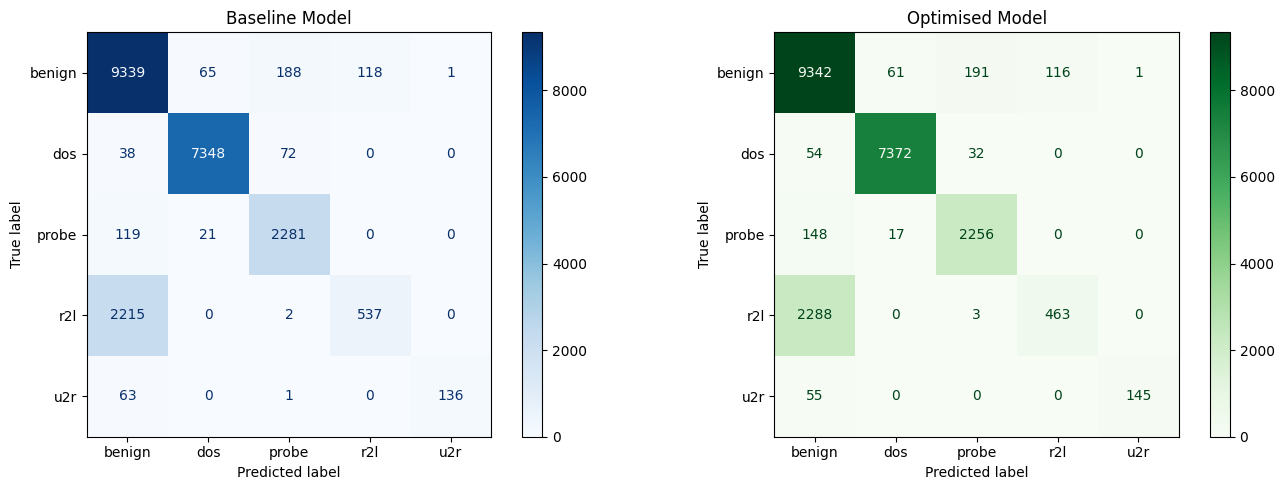

In [38]:
# Confusion Matrix (for appendix)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_baseline = confusion_matrix(y_test, y_pred_rf, labels=class_labels)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=class_labels)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Baseline Model')

cm_optimised = confusion_matrix(y_test, y_pred_optimised, labels=class_labels)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_optimised, display_labels=class_labels)
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('Optimised Model')

plt.tight_layout()
plt.savefig('../figures/ensemble_confusion_matrices.png', dpi=150)
plt.show()

---
## 9. Summary and Conclusions

In [39]:
print("="*70)
print("SUMMARY: ENSEMBLE CLASSIFIER FOR INTRUSION DETECTION")
print("="*70)

print("\n1. CLASSIFIER CATEGORY: Ensemble")
print("   Algorithms Evaluated: Random Forest, Extra Trees, AdaBoost")
print(f"   Best Baseline: {best_baseline_name}")

print("\n2. CLASSIFICATION TYPE: Multi-class (5 categories)")

print("\n3. BASELINE COMPARISON:")
print(baseline_comparison.to_string(index=False))

print("\n4. OPTIMISATION STRATEGIES:")
print("   a) Hyperparameter Tuning with RandomizedSearchCV")
for k, v in best_params.items():
    print(f"      - {k}: {v}")
print("   b) Feature Selection (Importance-based)")
print(f"      - Original: {X_train.shape[1]} features")
print(f"      - Selected: {len(selected_features)} features")

print("\n5. PERFORMANCE IMPROVEMENT:")
for _, row in comparison_df.iterrows():
    if row['Metric'] != 'Train Time (s)':
        print(f"   {row['Metric']}: {row['Baseline']:.4f} -> {row['Optimised']:.4f} ({row['Improvement %']:+.2f}%)")

print("\n" + "="*70)

SUMMARY: ENSEMBLE CLASSIFIER FOR INTRUSION DETECTION

1. CLASSIFIER CATEGORY: Ensemble
   Algorithms Evaluated: Random Forest, Extra Trees, AdaBoost
   Best Baseline: Random Forest

2. CLASSIFICATION TYPE: Multi-class (5 categories)

3. BASELINE COMPARISON:
    Algorithm  Accuracy  F1 (Weighted)  F1 (Macro)      MCC  Train Time (s)
Random Forest  0.871230       0.845266    0.779438 0.813972        3.246695
  Extra Trees  0.871540       0.847275    0.794635 0.813864        3.754451
     AdaBoost  0.733765       0.686147    0.475912 0.617307       21.734588

4. OPTIMISATION STRATEGIES:
   a) Hyperparameter Tuning with RandomizedSearchCV
      - n_estimators: 100
      - min_samples_split: 2
      - min_samples_leaf: 1
      - max_features: sqrt
      - max_depth: None
      - class_weight: balanced
   b) Feature Selection (Importance-based)
      - Original: 122 features
      - Selected: 38 features

5. PERFORMANCE IMPROVEMENT:
   Accuracy: 0.8712 -> 0.8684 (-0.32%)
   F1 (Weighted): 0.

In [40]:
# Save results
results_dict = {
    'classifier': 'Random Forest',
    'category': 'Ensemble',
    'classification_type': 'multi-class',
    'classes': class_labels,
    'baseline_comparison': baseline_comparison.to_dict('records'),
    'baseline_metrics': rf_metrics,
    'optimised_metrics': optimised_metrics,
    'baseline_mcc_per_class': rf_mcc_class,
    'optimised_mcc_per_class': opt_mcc_class,
    'optimisation_strategies': ['Hyperparameter Tuning', 'Feature Selection (Importance)'],
    'best_params': {k: str(v) for k, v in best_params.items()},
    'n_features_original': X_train.shape[1],
    'n_features_selected': len(selected_features)
}

with open('../results/ensemble_rf_results.json', 'w') as f:
    json.dump(results_dict, f, indent=2, default=str)
print("Results saved to: results/ensemble_rf_results.json")

Results saved to: results/ensemble_rf_results.json


In [41]:
# Save comparison tables
baseline_comparison.to_csv('../results/ensemble_baseline_comparison.csv', index=False)
comparison_df.to_csv('../results/ensemble_baseline_vs_optimised.csv', index=False)
mcc_comparison_df.to_csv('../results/ensemble_mcc_per_class.csv', index=False)
print("CSV files saved.")

CSV files saved.
